# Homework 3

Refer to the `README.md` in your GitHub repository for all instructions around partners, late work, and how to submit your assignment to Canvas.

In [2]:
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
# This may be necessary to ensure torch can load deterministic algorithms
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
from torchvision import datasets, transforms

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## GANs and Autoencoders

This homework assignment builds off the GAN notebook and the Autoencoder notebook that we saw in class. You may copy any code from those notebooks into your code.

For this assignment, you will combine the models introduced in those two notebooks to create a combined Autoencoder + GAN model. In particular, that will look something like this:

![Diagram of model architecture](https://github.com/cs449f23/lectures/raw/main/static/hw3_fig.png)

We're giving you the defined models below and the skeleton of the training code, and you just need to define the optimizers and write the loss functions to allow these models to train together.

If we write this in a functional representation, then the encoder $E(X)$ takes in a real image and outputs a $z$ vector, the generator $G(z)$ takes in a $z$ vector and outputs an image $\tilde X$, and the discriminator $D(X)$ takes in an image and outputs a scalar probability. $G(z)$ can either take in a $z$ sampled from a Gaussian distribution or produced by the encoder; we will evaluate your generation in both cases.

The autoencoder loss will be MSELoss comparing $X$ and $\tilde X$ and the generator and discriminator will be otherwise the same as in a GAN. The tricky component is to get the model to train and reduce all three losses simultaneously.

In [3]:
class MLPGenerator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPDiscriminator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""

        super().__init__()

        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg

        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]

        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPEncoder(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)


class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int,
                 latent_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):

        super().__init__()

        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            latent_size=latent_size,
            activation=activation_generator,
        )

        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=latent_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation=activation_generator
        )

        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            activation=activation_discriminator
        )

In [4]:
# Don't change the image size.
image_size = 28
# You shouldn't *need* to change latent size, but you can if you want
latent_size = 64
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Discriminator (and generator) loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()
# Autoencoder loss function: mean squared error between original and new image
autoencoder_loss_func = torch.nn.MSELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

In [5]:
# You shouldn't need to change this function.

def load_mnist(batch_size=64):

    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    } if torch.cuda.is_available() else {}

    # format image data, but do not normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # download MNIST data
    data = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transform
    )

    # load MNIST data
    loader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        **cuda_kwargs
    )

    return loader

## Coding Preliminaries (4 points)

You need to write code to get the model to train. There are a few design decisions you need to make; not all have a single correct answer. You **don't need to answer** these questions with written responses; just write your code. These questions are just guidance for how we will grade your code.

1. What are your loss functions?

  You will need to compute the loss of your model for each part of the model: `loss_discriminator`, `loss_generator`, and `loss_autoencoder`. You should look at the printout for these losses. Overall, we expect that each loss will decrease for at least *part* of the training time and the total loss should decrease monotonically.


2. How do you use optimizers to train your model?

  You will need to instantiate optimizer(s) from the `torch.nn.optim` module. You may want to more than one optimizer, so you can use different optimizers for different parts of your model. How many optimizers to use is up to you. Be sure to use `zero_grad()` to zero out gradients. You may want to use `detach()` as we did in the GAN notebook.


3. Can we reproduce your code?

  For full points, we must be able to run your notebook as is and reproduce (almost) exactly the same results.

In [6]:
# TODO: change these training hyperparameters

hidden_size = 256
number_of_hidden_layers = 2
learning_rate = 0.0002
epochs = 80
batch_size = 64
batch_limit = None

In [7]:
# Load MNIST dataset
# You only need to rerun this cell if you've changed `batch_size` above

mnist = load_mnist(batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Set the random seed. NOTE: don't change this
np.random.seed(1)
torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

model = Model(
    number_of_hidden_layers=number_of_hidden_layers,
    latent_size=latent_size,
    hidden_size=hidden_size,
    output_size=image_size*image_size,
).to(device)

opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)
opt_generator = torch.optim.Adam(model.generator.parameters(), lr=learning_rate)
opt_encoder = torch.optim.Adam(model.encoder.parameters(), lr=learning_rate)

loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
loss_ae = np.zeros(epochs)

for epoch in range(epochs):
    total_epoch_size = 0

    for batch_idx, batch_data in enumerate(mnist):

        # TODO: try debugging your model with a small batch_limit
        # of batches before training on the whole dataset
        # Set batch_limit = None to run on the full dataset.
        if batch_limit is not None and batch_idx >= batch_limit:
            break

        x_real, y_real = batch_data
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        # TODO: write your training code here to compute loss functions
        #   and use optimizer(s) to update your parameters
        loss_discriminator = torch.tensor(0)
        loss_generator = torch.tensor(0)
        loss_autoencoder = torch.tensor(0)

        ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################

        model.discriminator.zero_grad()

        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = model.discriminator(x_real)
        loss_real = discrim_loss_func(preds_real, y_real)

        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)

        # the x_fake.detach() is key here, otherwise the gradients would
        # follow through the generator when backprop is performed.
        preds_fake = model.discriminator(x_fake.detach())
        loss_fake = discrim_loss_func(preds_fake, y_fake)

        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()

        ########################################################################
        # STEP 2 and STEP 3: Train the generator and autoencoder
        ########################################################################

        # Zero the gradients for encoder and generator
        opt_encoder.zero_grad()
        opt_generator.zero_grad()

        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        preds_fake = model.discriminator(x_fake)

        z_encoded = model.encoder(x_real)
        x_recon = model.generator(z_encoded)

        loss_generator = discrim_loss_func(preds_fake, y_real)
        loss_autoencoder = autoencoder_loss_func(x_recon, x_real)
        total_loss = loss_generator + loss_autoencoder
        total_loss.backward()
        opt_encoder.step()
        opt_generator.step()

        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        loss_ae[epoch] += loss_autoencoder.detach().item() * n_batch
        total_epoch_size += n_batch

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size
    loss_ae[epoch] /= total_epoch_size

    if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
        total = loss_ae[epoch] + loss_g[epoch] + loss_d[epoch]
        log = "  ".join([
            f"Epoch: {epoch + 1:4d}",
            f"AE Loss: {loss_ae[epoch]:8.4f}",
            f"Gen Loss: {loss_g[epoch]:8.4f}",
            f"Dis Loss: {loss_d[epoch]:8.4f}",
            f"Total: {total:8.4f}",
        ])
        print(log)

PATH = '/content/gdrive/My Drive/NU/DL/HW3/model-spartacus.pth'
os.makedirs(os.path.dirname(PATH), exist_ok=True)
torch.save(model.state_dict(), PATH)


Epoch:    1  AE Loss:   0.1351  Gen Loss:   5.1738  Dis Loss:   0.1459  Total:   5.4549
Epoch:    8  AE Loss:   0.0655  Gen Loss:   7.7208  Dis Loss:   0.0450  Total:   7.8313
Epoch:   16  AE Loss:   0.0521  Gen Loss:   6.7130  Dis Loss:   0.0855  Total:   6.8506
Epoch:   24  AE Loss:   0.0358  Gen Loss:   3.2256  Dis Loss:   0.3767  Total:   3.6381
Epoch:   32  AE Loss:   0.0291  Gen Loss:   2.3386  Dis Loss:   0.5572  Total:   2.9249
Epoch:   40  AE Loss:   0.0247  Gen Loss:   2.1303  Dis Loss:   0.6065  Total:   2.7615
Epoch:   48  AE Loss:   0.0221  Gen Loss:   1.9722  Dis Loss:   0.6534  Total:   2.6477
Epoch:   56  AE Loss:   0.0201  Gen Loss:   1.9220  Dis Loss:   0.6581  Total:   2.6002
Epoch:   64  AE Loss:   0.0186  Gen Loss:   1.8466  Dis Loss:   0.6826  Total:   2.5479
Epoch:   72  AE Loss:   0.0187  Gen Loss:   1.7854  Dis Loss:   0.7187  Total:   2.5227
Epoch:   80  AE Loss:   0.0175  Gen Loss:   1.7369  Dis Loss:   0.7506  Total:   2.5050


## Generate new images (3 points)

Once you've trained your model, use this cell to generate images by sampling $z \sim {\mathcal N}(0, 1)$ and producing $G(z)$. We will grade this based on whether your generated images look like the handwritten digits from MNIST. While this is somewhat subjective, here is a rough rubric of how we plan to grade this:

- **0 points**: just blobs or static; no distinction between images

    ![0pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_0pts.png)

- **1 point**: if you squint, it might look like a digit

    ![1pt](https://github.com/cs449f23/lectures/raw/main/static/hw3_1pt.png)

- **2 points**: you can tell what digit each image is supposed to be

    ![2pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_2pts.png)

- **3 points**: you might not be able to tell it apart from an MNIST digit

    ![3pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_3pts.png)

Remember: we must be able to run your notebook from scratch and get similar results.

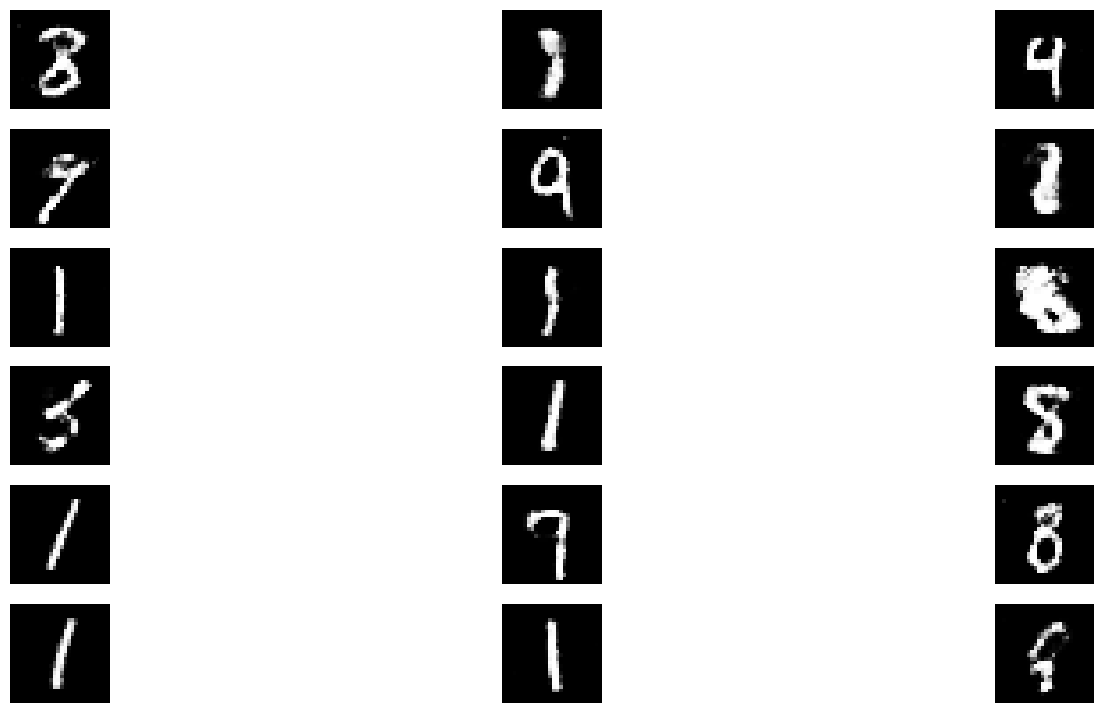

In [19]:
nrows, ncols = (6, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        output = model.generator(z).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()

## Auto-encode existing images (2 points)

Once you've trained your model, use this cell to generate images by choosing a random $X$ and generating $G(E(X))$. You should be able to reconstruct images with low reconstruction error. We will grade the "Reconstructed Image" column based on whether it looks like the "Original Image." We will grade the "Nearby Reconstruction" column based on whether it looks good (using the rubric above) and whether it is somewhat close to the "Original Image."

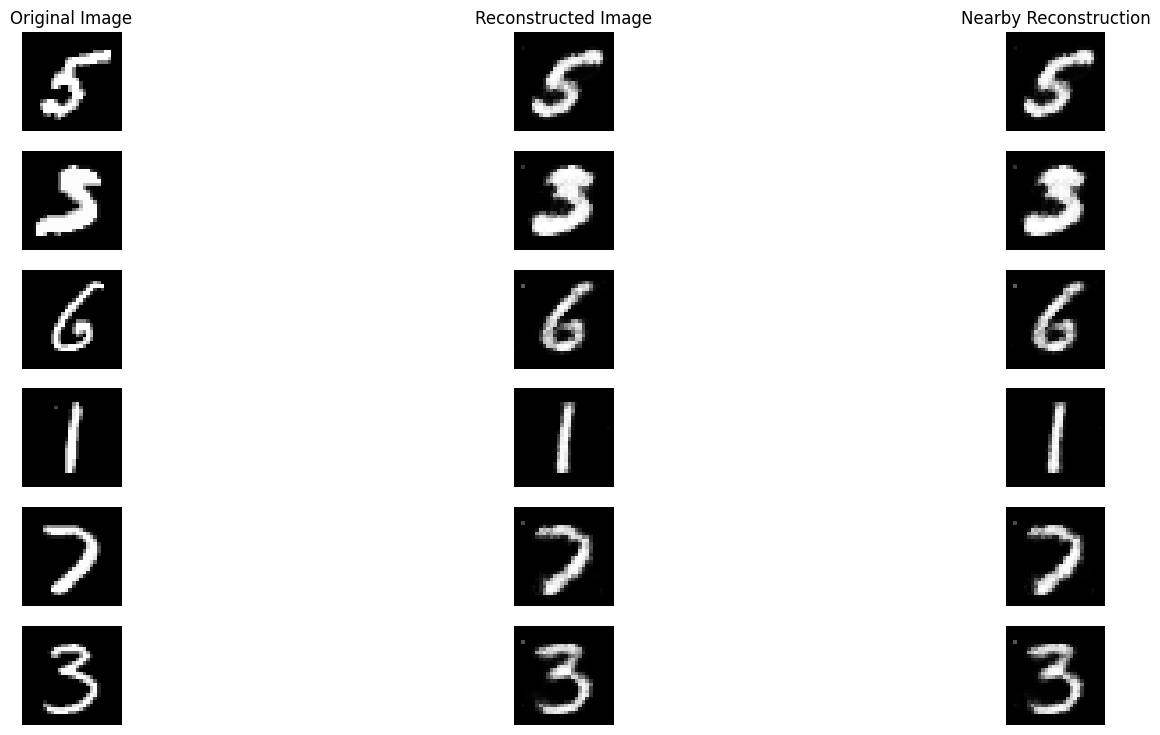

In [20]:
example_batch = next(iter(mnist))[0].to(device)
nrows, ncols = (6, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:nrows]

for row, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[row, 0].imshow(example_image.squeeze(), cmap='gray')
    axes[row, 0].axis('off')
    if row == 0:
        axes[row, 0].set_title("Original Image")

    z = model.encoder(example_image.flatten().unsqueeze(0).to(device))
    recons_img = model.generator(z).reshape(1, image_size, image_size).detach().cpu()

    axes[row, 1].imshow(recons_img.squeeze(), cmap='gray')
    axes[row, 1].axis('off')
    if row == 0:
        axes[row, 1].set_title("Reconstructed Image")

    z_nearby = z + torch.randn(1, latent_size).to(device)
    nearby = model.generator(z_nearby).reshape(1, image_size, image_size).detach().cpu()
    axes[row, 2].imshow(recons_img.squeeze(), cmap='gray')
    axes[row, 2].axis('off')
    if row == 0:
        axes[row, 2].set_title("Nearby Reconstruction")


plt.show()

## Conceptual questions (5 points)

Please submit your written answers to the questions in `problems.md` as a separate `hw3.pdf` file.